In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms



#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal
from scipy import linalg as la


#Librería de estadística
import scipy as sp
from scipy.stats import pearsonr,spearmanr

#librería para manejo de fechas
from datetime import datetime,timedelta

plt.style.use("seaborn")
mp.rcParams['xtick.labelsize']=15
mp.rcParams['ytick.labelsize']=15

mp.rcParams['axes.labelsize']=17

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

In [3]:
rutas = np.sort(glob.glob("/home/franklin/Documentos/GitHub/TDG/Dataset/Monthly/*.nc"))

In [4]:
[lat,sla,time,lon]=reading_netcdf(rutas[0])


latitude (45,) degrees_north
ssh (276, 45, 185) m
time (276,) hours since 1950-01-01
longitude (185,) degrees_east




In [9]:
lat

array([-3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  ,
       -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
        1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,
        3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,
        6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ],
      dtype=float32)

In [6]:
sla[sla<=-1000]=np.nan
da=[datetime(1950,1,1,0,0,0)+timedelta(hours=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)
new_array = np.array(date.to_pydatetime(), dtype=object)
sla_copy=sla

Se hace un suavizado 1 año, para eiminar la variabilidad mensual, estacional y semianual

In [7]:
for la in range (sla_copy.shape[1]):
    for lo in range(sla_copy.shape[2]):
        a=sla_copy[:,la,lo]
        serie_test=pd.Series(a,index=date)
        serie_rolling=serie_test.rolling(12).mean()
        sla_copy[:,la,lo]=serie_rolling.values

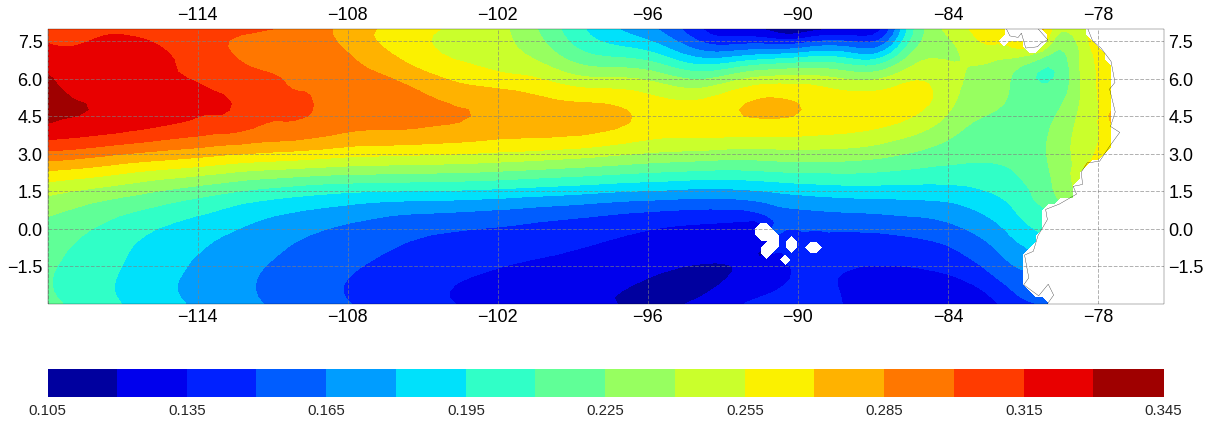

In [8]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,sla_copy[20,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## Formando la matriz A

In [10]:
sla_copy.shape

(276, 45, 185)

In [11]:
A=np.reshape(sla_copy[12:,:,:],(len(time)-12,len(lon)*len(lat)))

In [12]:
A.shape

(264, 8325)

In [13]:
fila1_A = np.array(A[0,:])

In [14]:
fila1_A

array([0.25681326, 0.25493128, 0.25307474, ...,        nan,        nan,
              nan])

In [15]:
#Se hallan los índices de las posiciones que son tierra (NaN)
pos_cont = np.isnan(fila1_A)
pos_mar  = (np.where(pos_cont == False))[0]

#Se seleccionan solo las posiciones asociadas al mar
A_no_land = A[:, pos_mar]
print (np.shape(A))
print (np.shape(A_no_land))

(264, 8325)
(264, 7406)


Se escala la matriz de A_no_land para que queden correlaciones y no covarianzas

In [16]:
A_corr=np.copy(A_no_land)
for i in range(A_no_land.shape[1]):
    A_corr[:,i]=(A_no_land[:,i]-np.mean(A_no_land[:,i]))/np.std(A_no_land[:,i])

In [17]:
A_corr.shape

(264, 7406)

## Haciendo la EOF

In [18]:
A_no_land

array([[0.25681326, 0.25493128, 0.25307474, ..., 0.28903572, 0.29231646,
        0.29600411],
       [0.2443261 , 0.24236783, 0.24048585, ..., 0.27873572, 0.28234708,
        0.28633991],
       [0.23453475, 0.23280536, 0.23112684, ..., 0.2723777 , 0.27593819,
        0.27993103],
       ...,
       [0.36444187, 0.36243273, 0.36057619, ..., 0.38005717, 0.38382112,
        0.38786482],
       [0.37654754, 0.3746147 , 0.37285989, ..., 0.3883226 , 0.39195939,
        0.3957742 ],
       [0.38941618, 0.38758507, 0.38590655, ..., 0.3972747 , 0.40063173,
        0.40411593]])

In [19]:
U,S,Vh=np.linalg.svd(A_no_land)

In [20]:
U.shape,S.shape,Vh.shape

((264, 264), (264,), (7406, 7406))

### Modos de oscilación

Text(0, 0.5, 'Porcentaje de varianza')

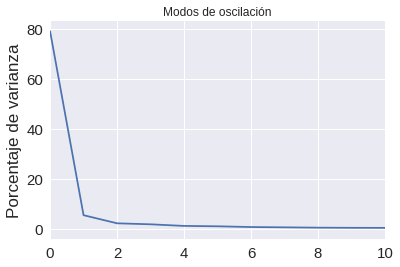

In [21]:
plt.figure()
plt.plot((S/np.sum(S))*100)
plt.xlim(0,10)
plt.title("Modos de oscilación")
plt.ylabel("Porcentaje de varianza")

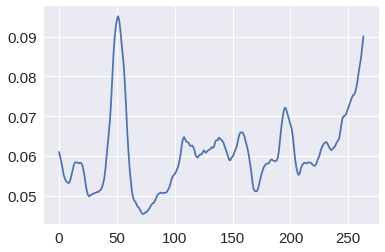

In [22]:
plt.plot(U[:,0]*-1)
mod1=pd.Series(U[:,0]*-1)
max_amp=mod1.idxmax()
min_amp=mod1.idxmin()

## Comparando el primer modo con el ONI

In [23]:
dataset_oni=pd.read_excel(r"/home/franklin/Documentos/GitHub/TDG/Dataset/oni index.xlsx").set_index("Year")

In [24]:
data=dataset_oni.values.ravel()
fechas=pd.date_range("1950-01-01","2019-01-01",freq="M")
date_oni=[i-timedelta(days=15) for i in fechas]
serie_oni_d=pd.Series(data=data,index=date_oni)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(727944.5, 735948.5)

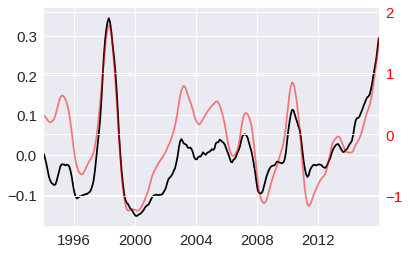

In [25]:
fig,ax=plt.subplots(1,1)
ax.plot(date[12:],(U[:,0]*-1-np.mean(U[:,0]*-1))*10,c='k')
ax2 = ax.twinx()
ax2.plot(serie_oni_d.rolling(12).mean()[365:],c='red',alpha=0.5,label="ONI")
ax2.tick_params(axis='y', labelcolor='red')
ax.set_xlim(date[12],date[-1])



### Pintando la EOF

In [26]:
verify=np.copy(fila1_A)

In [27]:
iters=0
for i in range(len(verify)):
    if np.isnan(verify[i])==True:
        iters=iters
    if np.isnan(verify[i])==False:
        verify[i]==Vh[0,iters]
        iters=iters+1

In [28]:
EOF=verify.reshape([len(lat),len(lon)])

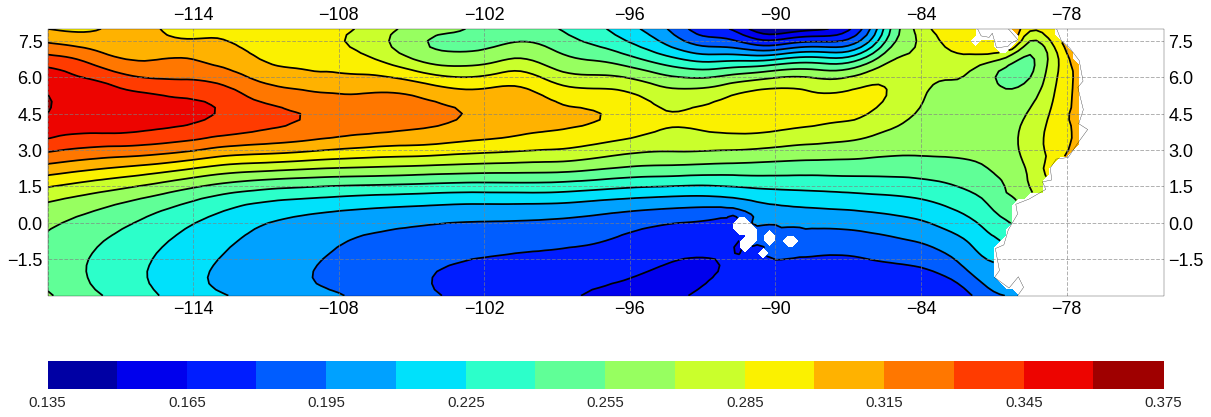

In [29]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,EOF,20,transform=ccrs.PlateCarree(),cmap="jet")
ct=ax.contour(x,y,EOF,20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

In [85]:
# EOF multiplicada por los valores propios
matriz_EOF=np.zeros([len(U[:,0]),len(lat),len(lon)])
for i in range(len(U[:,0])):
    matriz_EOF[i,:,:]=EOF*U[i,0]*-10

### Máxima amplitud

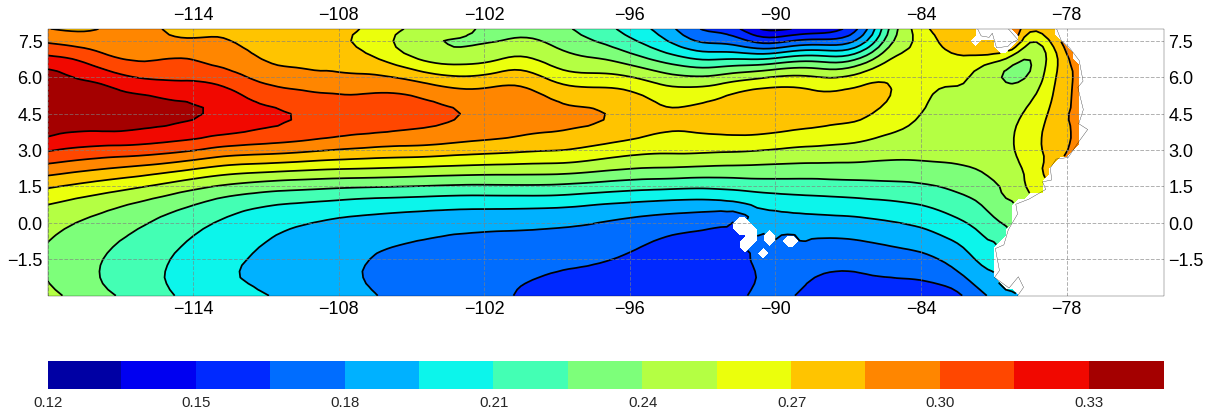

In [86]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,matriz_EOF[max_amp,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
ct=ax.contour(x,y,matriz_EOF[max_amp,:,:],20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

### Mínima amplitud

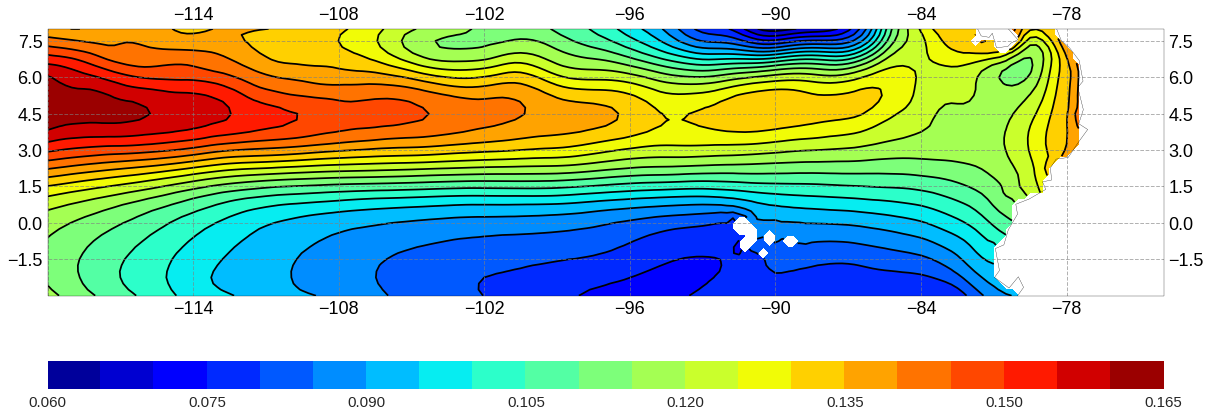

In [87]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,matriz_EOF[min_amp,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
ct=ax.contour(x,y,matriz_EOF[min_amp,:,:],20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## EOF Extendida

Será posible que esta estructura espacial se desplaza en el tiempo?

In [88]:
A_no_land

array([[0.25681326, 0.25493128, 0.25307474, ..., 0.28903572, 0.29231646,
        0.29600411],
       [0.2443261 , 0.24236783, 0.24048585, ..., 0.27873572, 0.28234708,
        0.28633991],
       [0.23453475, 0.23280536, 0.23112684, ..., 0.2723777 , 0.27593819,
        0.27993103],
       ...,
       [0.36444187, 0.36243273, 0.36057619, ..., 0.38005717, 0.38382112,
        0.38786482],
       [0.37654754, 0.3746147 , 0.37285989, ..., 0.3883226 , 0.39195939,
        0.3957742 ],
       [0.38941618, 0.38758507, 0.38590655, ..., 0.3972747 , 0.40063173,
        0.40411593]])

In [30]:
# Denicion del numero de rezagos
print (np.shape(A_no_land))
n_months = 36
step     = 6
n_rez    = int(n_months/step)

(264, 7406)


In [31]:
n_rez

6

In [32]:
A_extended = np.ones((np.shape(A_no_land)[0] - n_months, np.shape(A_no_land)[1]*n_rez ))

In [33]:
for i in range(0,n_rez):
    A_extended[:,i*A_no_land.shape[1]:i*A_no_land.shape[1]+A_no_land.shape[1]]=\
        A_no_land[i*step:i*step+(np.shape(A_no_land)[0]-n_months),:]

In [34]:
cov_extendida=np.dot(A_extended,A_extended.T)
val1_ext, vec1_ext=la.eig(cov_extendida)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 10)

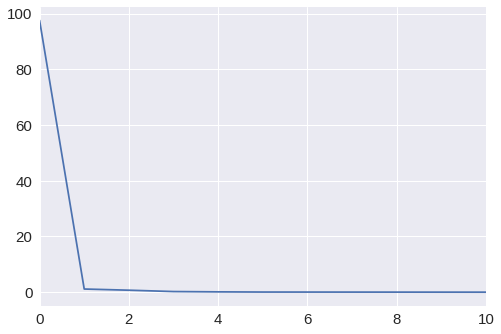

In [35]:
plt.plot((val1_ext/np.sum(val1_ext))*100)
plt.xlim(0,10)

In [36]:
EOFs_ext = np.dot(vec1_ext.T,A_extended)

In [37]:
EOFs_ext.shape

(228, 44436)

In [38]:
EOF1_ext = EOFs_ext[0,:]

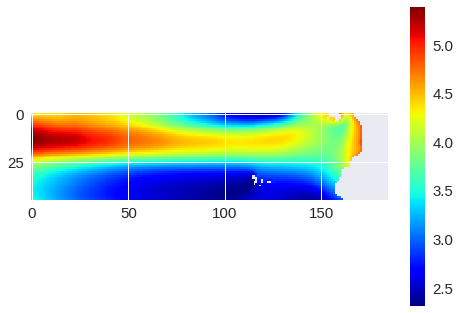

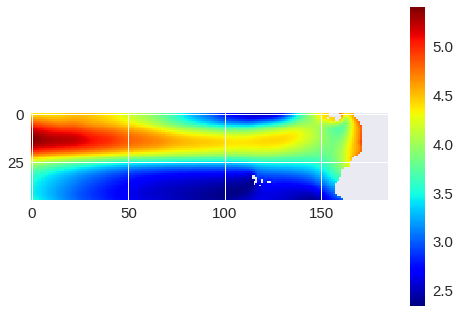

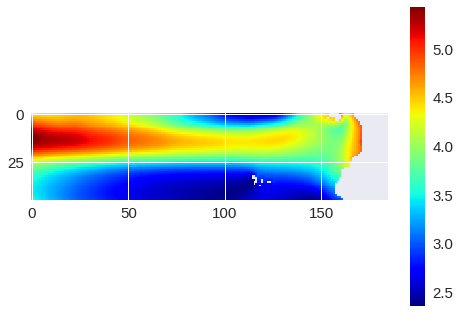

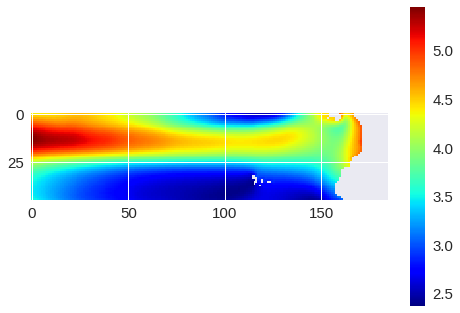

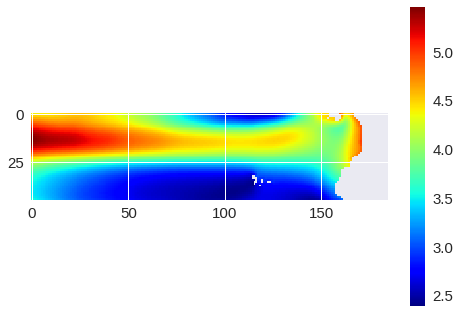

In [51]:
EOF1ext_mres = np.ones((n_rez, len(lat), len(lon))) * np.nan

for j in range(0, n_rez-1):
    EOF1ext_m = np.ones(len(fila1_A))*np.nan
    EOF1ext_m[pos_mar] = EOF1_ext[j*len(pos_mar):j*len(pos_mar)+len(pos_mar)]
    EOF1ext_res = np.reshape(EOF1ext_m, (len(lat), len(lon)))
    plt.imshow(EOF1ext_res[::-1,:],cmap='jet')
    plt.colorbar()
    plt.show()

In [ ]:
U_ext,S_ext,Vh_ext=np.linalg.svd(A_extended)